In [1]:
import os
import pandas as pd

In [9]:
print(os.getcwd())
df = pd.read_csv("winequality-red.csv", sep=";")
df.head()

/Users/Samuele 1/Documents/GitHub/AAAMLP/cross_val


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

In [4]:
quality_mapping = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}
df.loc[:,"quality"] = df.quality.map(quality_mapping)
df["quality"].unique()

array([2, 3, 4, 1, 5, 0])

### Let's control the distribution of qualities to see if we need kfold or stratified kfold

We clearly need a stratified kfold as we don't have evenly distributed counts


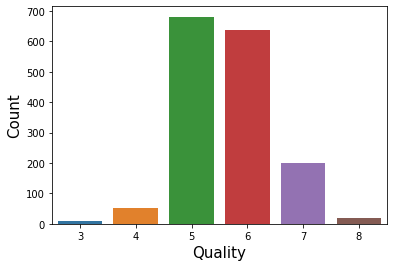

In [14]:
import seaborn as sns

b = sns.countplot(x='quality', data=df)
b.set_xlabel("Quality", fontsize=15)
b.set_ylabel("Count", fontsize=15)

print("We clearly need a stratified kfold as we don't have evenly distributed counts")

In [15]:
from sklearn import model_selection

# Creation of a new column called kfold and filled with -1
df["kfold"] = -1

# Randomize rows of train
df = df.sample(frac=1).reset_index(drop=True)

# Fetch targets
y = df.quality.values

# Initiate the stratified kfold class from model_selection module with 5 folds
kf = model_selection.StratifiedKFold(n_splits=6)

# Fill the new fold column
for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
    df.loc[val_, 'kfold'] = fold

In [16]:
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kfold
1594,7.3,0.51,0.18,2.1,0.070,12.0,28.0,0.99768,3.52,0.73,9.5,6,5
1595,7.8,0.54,0.26,2.0,0.088,23.0,48.0,0.99810,3.41,0.74,9.2,6,5
1596,7.8,0.41,0.68,1.7,0.467,18.0,69.0,0.99730,3.08,1.31,9.3,5,5
1597,8.6,0.49,0.28,1.9,0.110,20.0,136.0,0.99720,2.93,1.95,9.9,6,5
1598,7.2,0.58,0.03,2.3,0.077,7.0,28.0,0.99568,3.35,0.52,10.0,5,5


In [17]:
df_train = df.loc[(df['kfold'] >= 0) & (df['kfold'] <= 4)]
df_test = df.loc[(df['kfold'] == 5)]

In [21]:
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kfold
0,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2,6,0
1,6.7,0.56,0.09,2.9,0.079,7.0,22.0,0.99669,3.46,0.61,10.2,5,0
2,7.1,0.27,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6,0
3,9.9,0.35,0.55,2.1,0.062,5.0,14.0,0.99710,3.26,0.79,10.6,5,0
4,8.3,0.65,0.10,2.9,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,5,0


Train accuracy increases, but not test accuracy. We have overfitted!


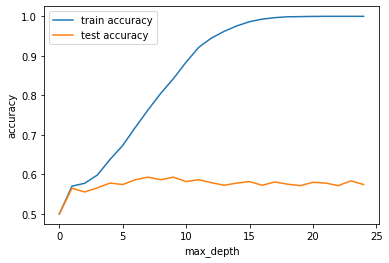

In [28]:
from sklearn import tree
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

depths = np.arange(0, 25)

train_acc_avg = [0.5]
val_acc_avg = [0.5]



for depth in depths[1:]:

    train_acc = []
    val_acc = []

    for fold in np.arange(0,4):

        # Decision tree
        clf = tree.DecisionTreeClassifier(max_depth=depth)

        # Columns used aka features
        cols = ['fixed acidity',
        'volatile acidity',
        'citric acid',
        'residual sugar',
        'chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density',
        'pH',
        'sulphates',
        'alcohol']

        df_train_fold = df_train.loc[(df_train['kfold'] != fold)]
        df_val_fold = df_train.loc[(df_train['kfold'] == fold)]

        # Training the model
        clf.fit(df_train_fold[cols], df_train_fold.quality)

        train_predictions = clf.predict(df_train_fold[cols])

        val_prediction = clf.predict(df_val_fold[cols])

        train_accuracy = metrics.accuracy_score(
            df_train_fold.quality,
            train_predictions
            )

        val_accuracy = metrics.accuracy_score(
            df_val_fold.quality,
            val_prediction
        )

        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

    train_acc_avg.append(np.average(train_acc))
    val_acc_avg.append(np.average(val_acc))

    


plt.plot(depths, train_acc_avg)
plt.plot(depths, val_acc_avg)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'test accuracy'])
print('Train accuracy increases, but not test accuracy. We have overfitted!')